TP2

Mariana Chang Ieong 2074331

Zakarya Khnissi 198964

In [43]:
import numpy as np
import matplotlib.pyplot as py
from numpy import linalg as LA
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

In [44]:
def rgb2yuv(image):
    for i in range(len(image)):
        for j in range(len(image[0])):
            # Convert RGB to YUV
            R = image[i][j][0]
            G = image[i][j][1]
            B = image[i][j][2]

            Y = (R + 2*G + B)/4
            U = B - G
            V = R - G

            image[i][j][0] = Y
            image[i][j][1] = U
            image[i][j][2] = V
    return image
    
def yuv2rgb(image):
    for i in range(len(image)):
        for j in range(len(image[0])):
            # Convert YUV to RGB
            Y = image[i][j][0]
            U = image[i][j][1]
            V = image[i][j][2]
            
            G = Y - (U + V)/4
            R = V + G
            B = U + G

            image[i][j][0] = R
            image[i][j][1] = G
            image[i][j][2] = B
    return image

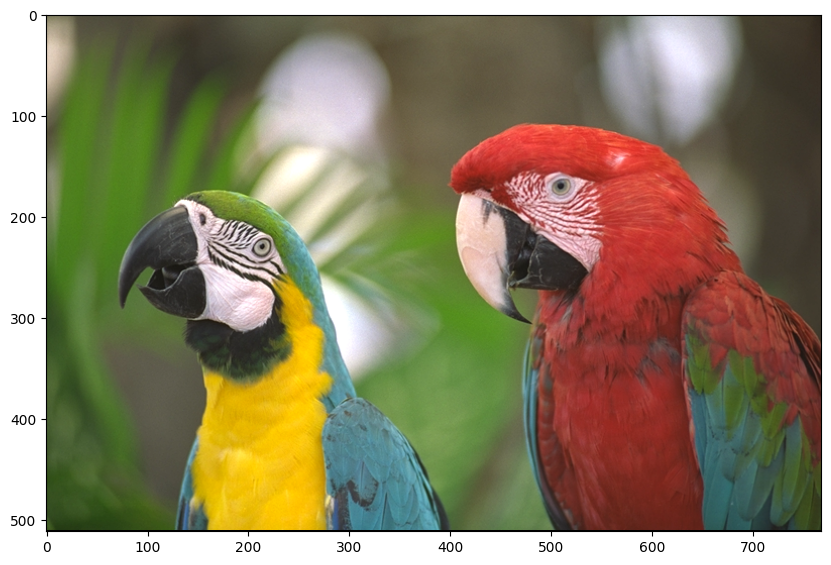

In [45]:
fig1 = py.figure(figsize = (10,10))
imagelue = py.imread('./images/kodim23.png')
image=imagelue.astype('double')
rgb2yuv(image)
        
py.imshow(imagelue)
py.show()

Calcul des valeurs moyennes des RGB. Nécessaire pour calculer la matrice de covariance des RGB

In [46]:
sommeR = 0.0
sommeG = 0.0
sommeB = 0.0
for i in range(len(image)):
    for j in range(len(image[0])):
        sommeR=sommeR+image[i][j][0]
        sommeG=sommeG+image[i][j][1]
        sommeB=sommeB+image[i][j][2]
        
nbPixels = len(image)*len(image[0])        
MoyR= sommeR / nbPixels
MoyG= sommeG / nbPixels
MoyB= sommeB / nbPixels

print(MoyR)
print(MoyG)
print(MoyB)

0.4084784910860397
-0.13255675362936495
0.047318242022773425


Calcul de la matrice de covariance des RGB

In [47]:
covRGB = np.zeros((3,3), dtype = "double")
for i in range(len(image)):
    for j in range(len(image[0])):
        vecTemp=[[image[i][j][0] - MoyR], [image[i][j][1]] - MoyG, [image[i][j][2] - MoyB]]
        vecProdTemp = np.dot(vecTemp,np.transpose(vecTemp))
        covRGB = np.add(covRGB,vecProdTemp)

covRGB = covRGB / nbPixels        
print(covRGB)

[[ 0.03197084 -0.00396979 -0.00195546]
 [-0.00396979  0.03021584  0.00529967]
 [-0.00195546  0.00529967  0.03526337]]


Calcul des vecteurs propres et valeurs propres

In [48]:
eigval, eigvec = LA.eig(covRGB)
print(eigval)
print()
print(eigvec)

[0.04038478 0.03125505 0.02581022]

[[-0.42463302  0.80548503 -0.41337713]
 [ 0.54323708 -0.13858226 -0.82806306]
 [ 0.72427914  0.57618471  0.37872273]]


Pour illustrer les bénéfices du changement de repère, une composante sur trois sera supprimée dans le nouveau repère. a=Mb, où b est la composant RGB - la moyenne, M la matrice de transformation de repère, et a est la composante dans l'espace des vecteurs propres. 

In [49]:

def transformKL(image, eigvec, MoyR, MoyG, MoyB, quantification):
    eigvec = np.transpose(eigvec)
    imageKL = np.copy(image)

    vecMoy =[[MoyR], [MoyG], [MoyB]] 


    for i in range(len(image)):
        for j in range(len(image[0])):
            vecTemp=[[image[i][j][0]], [image[i][j][1]], [image[i][j][2]]]
            #a=Mb
            imageKL[i][j][:] = np.reshape(np.dot(eigvec,np.subtract(vecTemp,vecMoy)),(3))

    max0 = np.amax(imageKL[:,:,0])
    min0 = np.amin(imageKL[:,:,0])
    max1 = np.amax(imageKL[:,:,1])
    min1 = np.amin(imageKL[:,:,1])
    max2 = np.amax(imageKL[:,:,2])
    min2 = np.amin(imageKL[:,:,2])

    step0 = (max0 - min0) / 2**quantification[0]
    step1 = (max1 - min1) / 2**quantification[1]
    step2 = (max2 - min2) / 2**quantification[2]
    
    # Faire la quantification (8/8/4, etc.)
    for i in range(len(imageKL)):
        for j in range(len(imageKL[0])):
            imageKL[i][j][0] = (imageKL[i][j][0] - min0) // step0 * step0 + min0
            imageKL[i][j][1] = (imageKL[i][j][1] - min1) // step1 * step1 + min1
            imageKL[i][j][2] = (imageKL[i][j][2] - min2) // step2 * step2 + min2

    return imageKL
        
#step = plus grande valeur - plus petite valeur / 2^nbBits	

#question 2
# creer une fonction avec nom du fichier, choix de lespace colorimetrique, quantification
# pour 8/8/4, en gros on veut diviser en 2^4 niveaux, soit 16 niveaux, donc on voudrais diviser l'intervalle [0,255] en 16 intervalles de taille 16
# 40 compressions car 8*5 = 40. on a deja 8/8/8, 8/8/4, 8/8/0, 8/8/4, il faut trouver la derniere quantification, soit 8/4/4

#question 3
# 25 compressions car 5*5 = 25. blabla copilot: on a deja 8/8/8, 8/8/4, 8/8/0, 8/8/4, 8/4/4, il faut trouver la derniere quantification, soit 8/4/0

Les images dans les repères définis par les vecteurs propres ne peuvent pas être affichées. Toutefois, en éliminant un axe, on a retiré 33% de l'information. Une composante vaut zéro. Exemple:

In [50]:
# print(imageKL[10][10][:])

En faisant la transformée inverse, on peut voir les images qui résultent de la compression. b=inv(M)a. Dans le code, on utilse pinv (Pseudo-inverse), car la matrice est parfois singulière. Il faut faire b + moyenne.

In [51]:
def transformInverseKL(imageKL, eigvec, MoyR, MoyG, MoyB):
    eigvec = LA.pinv(np.transpose(eigvec))
    imageOutput = np.copy(image)
    vecMoy = [MoyR, MoyG, MoyB]

    for i in range(len(image)):
        for j in range(len(image[0])):
            # b = inv(M) * a
            vecTemp = [[imageKL[i][j][0]], [imageKL[i][j][1]], [imageKL[i][j][2]]]
            
            imageOutput[i][j][:] = np.add(np.reshape(np.dot(eigvec, vecTemp), (3)), vecMoy)
    return imageOutput

In [52]:
def rgb2gray(rgb):
    return np.dot(rgb[:,:], [0.299, 0.587, 0.114])

In [53]:
def showPicture(image, eigvec, MoyR, MoyG, MoyB, quantification):
    imageKL = transformKL(image, eigvec, MoyR, MoyG, MoyB, quantification)
    imageOutput = transformInverseKL(imageKL, eigvec, MoyR, MoyG, MoyB)
    imageOutput = imageOutput.astype('uint8')
    py.imshow(image)
    py.show()
    image = rgb2gray(image)
    imageOutput = rgb2gray(imageOutput)

In [54]:
def calculatePSNR(image, eigvec, MoyR, MoyG, MoyB, quantification):
    imageKL = transformKL(image, eigvec, MoyR, MoyG, MoyB, quantification)
    imageOutput = transformInverseKL(imageKL, eigvec, MoyR, MoyG, MoyB)
    imageOutput = imageOutput.astype('uint8')
    return peak_signal_noise_ratio(image, imageOutput)

def calculateSSIM(image, eigvec, MoyR, MoyG, MoyB, quantification):
    imageKL = transformKL(image, eigvec, MoyR, MoyG, MoyB, quantification)
    imageOutput = transformInverseKL(imageKL, eigvec, MoyR, MoyG, MoyB)
    imageOutput = imageOutput.astype('uint8')
    return structural_similarity(image, imageOutput)

def calculateCompressionRate(quantification):
    return (1 - sum(quantification[0], quantification[1], quantification[2])) / 24

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


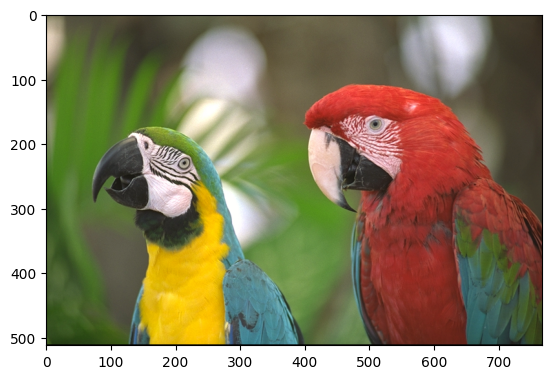

UnboundLocalError: cannot access local variable 'G' where it is not associated with a value

In [55]:
image=imagelue.astype('double')
imageKL888 = transformKL(image, eigvec, MoyR, MoyG, MoyB, [8,8,8])
imageout888 = transformInverseKL(imageKL888, eigvec, MoyR, MoyG, MoyB)
# imageout = np.clip(imageKL,0,255)
imageout888= imageout888.astype('double')
py.imshow(imageout888)
py.show()
image = yuv2rgb(image)
image = rgb2gray(image)
imageout888 = rgb2gray(imageout888)
print(peak_signal_noise_ratio(image, imageout888))
print(structural_similarity(image, imageout888, data_range=image.max() - image.min()))

Résultat sans l'axe de faible énergie. L'impact sur l'image est minime. 8/8/4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


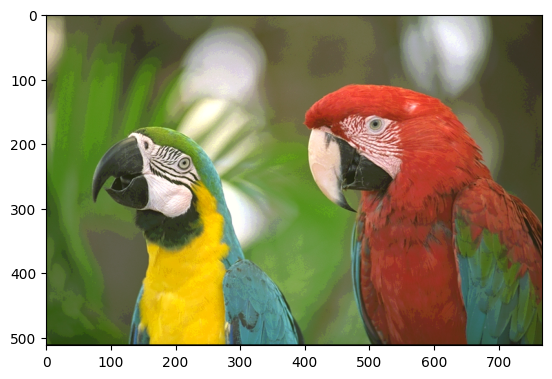

33.02880491283479
0.9445645847512877


In [ ]:
image=imagelue.astype('double')
imageKL884 = transformKL(image, eigvec, MoyR, MoyG, MoyB, [8,8,4])
imageout884 = transformInverseKL(imageKL884, eigvec, MoyR, MoyG, MoyB)
# imageout = np.clip(imageKL,0,255)
imageout884= imageout884.astype('double')
py.imshow(imageout884)
py.show()
image = yuv2rgb(image)
image = rgb2gray(image)
imageout884 = rgb2gray(imageout884)
print(peak_signal_noise_ratio(image, imageout884))
print(structural_similarity(image, imageout884, data_range=image.max() - image.min()))

Résultat sans l'axe de faible énergie. L'impact sur l'image est minime. 8/8/0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


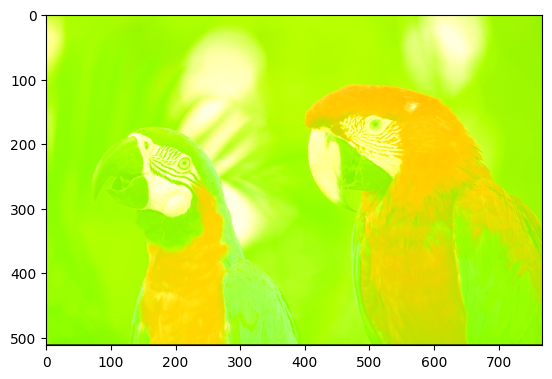

7.863191158698415
0.7135148800734041


In [ ]:
image=imagelue.astype('double')
imageKL880 = transformKL(image, eigvec, MoyR, MoyG, MoyB, [8,8,0])
imageout880 = transformInverseKL(imageKL880, eigvec, MoyR, MoyG, MoyB)
# imageout = np.clip(imageKL,0,255)
imageout880= imageout880.astype('double')
py.imshow(imageout880)
py.show()
image = yuv2rgb(image)
image = rgb2gray(image)
imageout880 = rgb2gray(imageout880)
print(peak_signal_noise_ratio(image, imageout880))
print(structural_similarity(image, imageout880, data_range=image.max() - image.min()))

Résultat sans l'axe de moyenne énergie. L'image assez dégradée. 8/0/8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


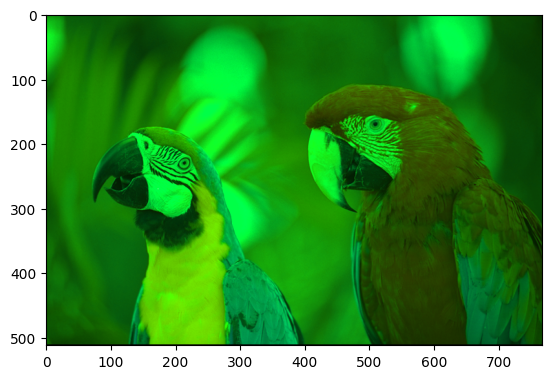

18.18604642456012
0.9304892373615408


In [ ]:
image=imagelue.astype('double')
imageKL808 = transformKL(image, eigvec, MoyR, MoyG, MoyB, [8,0,8])
imageout808 = transformInverseKL(imageKL808, eigvec, MoyR, MoyG, MoyB)
imageout808= imageout808.astype('double')
py.imshow(imageout808)
py.show()
image = yuv2rgb(image)
image = rgb2gray(image)
imageout808 = rgb2gray(imageout808)
print(peak_signal_noise_ratio(image, imageout808))
print(structural_similarity(image, imageout808, data_range=image.max() - image.min()))